# 概要
- 101クラス分類
- 対象：料理画像
- VGG16による転移学習
    1. 全結合層
    1. 全層
- Random exchange2
    - rx2_param.min_block_size = 4
    - rx2_param.max_block_size = 32
    - rx2_param.n = 32
    - rx2_param.nb_type = 8
- リサイズ前の画像に対して適用
- EarlyStopping
    - 監視対象をval_accに変更

In [1]:
RUN = 201

# 使用するGPUを指定

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# 使用するGPUメモリの制限

In [3]:
import tensorflow as tf

tf_ver = tf.__version__

if tf_ver.startswith('1.'):
    from tensorflow.keras.backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.log_device_placement = True
    sess = tf.Session(config=config)
    set_session(sess)

# matplotlibでプロットしたグラフをファイルへ保存

In [4]:
import os
def save_fig(plt, file_prefix):
    if file_prefix == '':
        return
    
    parent = os.path.dirname(os.path.abspath(file_prefix))
    os.makedirs(parent, exist_ok=True)
    plt.savefig(f'{file_prefix}.pdf', transparent=True, bbox_inches='tight', pad_inches = 0)
    plt.savefig(f'{file_prefix}.png', transparent=True, dpi=300, bbox_inches='tight', pad_inches = 0)

# 指定フォルダ以下にある画像リストを作成
- サブフォルダはラベルに対応する数字であること
- TOP_DIR
  - 0
    - 00001.jpg
    - 00002.jpg
  - 1
    - 00003.jpg
    - 00004.jpg

In [5]:
import pathlib
import random
import os

TOP_DIR = '/data1/Datasets/Food-101/03_all'

sub_dirs = pathlib.Path(TOP_DIR).glob('*/**')

label2files = dict()
for s in sub_dirs:
    files = pathlib.Path(s).glob('**/*.jpg')
    label = int(os.path.basename(s))
    label2files[label] = list(files)

# 画像とラベルを訓練データと検証データに分割する

In [6]:
ratio = 0.8
train_list = []
train_labels = []

val_list = []
val_labels = []

for k, v in label2files.items():
    random.shuffle(v)
    N = len(v)
    N_train = int(N * ratio)
    train_list.extend(v[:N_train])
    train_labels.extend([k] * N_train)
    
    val_list.extend(v[N_train:])
    val_labels.extend([k] * (N - N_train))
    
NUM_CLASSES = len(label2files.keys())

# VGGモデルのロード

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16


# 既存の1000クラスの出力を使わないため、
# `incliude_top=False`として出力層を含まない状態でロード
vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))

# モデルのサマリを確認。出力層が含まれてないことがわかる
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# VGG16を利用したモデルの作成と学習方法の設定

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten


# モデルを編集し、ネットワークを生成する関数の定義
def build_transfer_model(vgg16):
    
    # 読み出したモデルを使って、新しいモデルを作成
    model = Sequential(vgg16.layers)

    # 読み出した重みの一部は再学習しないように設定。
    # ここでは、追加する層と出力層に近い層の重みのみを再学習
    for layer in model.layers[:15]:
        layer.trainable = False
        
    # 追加する出力部分の層を構築
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

# ランダム交換

## パラメータクラス

In [9]:
class RandomExchangeParam2():
    def __init__(self):
        # 最小ブロックサイズ
        self.min_block_size = 4
        
        # 最大ブロックサイズ
        self.max_block_size = 32
        
        # 交換ブロック数
        self.n = 100
        
        # 近傍タイプ
        self.nb_type = 4
        
    def gen_block_sizes(self):
        return np.random.randint(self.min_block_size, high=self.max_block_size, size=self.n)
    
    def gen_block_params(self, img_height, img_width):
        sizes = np.random.randint(self.min_block_size, high=self.max_block_size, size=self.n)
        xs = np.zeros(self.n, dtype='int')
        ys = np.zeros(self.n, dtype='int')
        for i in range(self.n):
            xs[i] = np.random.randint(sizes[i], high=img_width-sizes[i]*2-1)
            ys[i] = np.random.randint(sizes[i], high=img_height-sizes[i]*2-1)
            
        nbs = np.random.randint(0, high=self.nb_type-1, size=self.n)

        return sizes, ys, xs, nbs

## 関数

In [10]:
import numpy as np
from PIL import Image

def random_exchange2(image, rx2_param):
    """
    格子状の座標を起点にブロック単位で画素を近傍ブロックと入れ替える。
    
    Parameters
    ----------
    image: PIL.Image
        画像
    rx2_param: RandomExchangeParam2
        交換用パラメータ
        
    Returns
    -------
    image: 処理された画像
    
    """
    image_data = np.array(image)
    ny, nx = image_data.shape[0:2]
    
    bs, ry, rx, nbs = rx2_param.gen_block_params(ny, nx)

    # 左右上下の4近傍いずれかと入れ替え
    if (rx2_param.nb_type == 4):
        ox = [-1, 0, 1, 0]
        oy = [0, -1, 0, 1]
    else: # 8近傍
        ox = [-1, 0, 1, 1, 1, 0, -1, -1]
        oy = [-1, -1, -1, 0, 1, 1, 1, 0]

    for b, sy, sx, db in zip(bs, ry, rx, nbs):
        dy = sy + oy[db] * b
        dx = sx + ox[db] * b
        image_data[sy:sy+b,sx:sx+b,:], image_data[dy:dy+b, dx:dx+b, :] = image_data[dy:dy+b, dx:dx+b, :], image_data[sy:sy+b,sx:sx+b,:]
        
    return Image.fromarray(image_data)

# 画像ファイルリストとラベルから教師データを生成するクラス

In [11]:
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf

class ImageSequence(tf.keras.utils.Sequence):
    def __init__(self, file_list, labels, batch_size, rx_param=None, image_shape=(224, 224), shuffle=True, horizontal_flip=True):
        self.file_list = np.array(file_list)
        self.labels = to_categorical(labels)
        self.batch_size = batch_size
        self.rx_param = rx_param
        self.image_shape = image_shape
        self.shuffle = shuffle
        self.horizontal_flip = horizontal_flip
        
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        idx = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        
        y = self.labels[idx]
        
        files = self.file_list[idx]

        x = []
        for f in files:
            try:
                img = Image.open(f)
                
                # 正しいデータはRGB画像
                # データセットの中には、グレースケール画像が入っている可能性がある。
                # RGBに変換して、正しいデータと次元を揃える                
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                if self.rx_param:
                    img = random_exchange2(img, self.rx_param)                

                img = img.resize(self.image_shape, Image.BILINEAR)
                
#                 if self.rx_param:
#                     img = random_exchange2(img, self.rx_param)                

                img = img_to_array(img)
                img = preprocess_input(img) / 255.0
                if self.horizontal_flip and np.random.random() > 0.5:
                    img = img[:,::-1, :]
                    
                x.append(np.expand_dims(img, axis=0))
            except:
                print(f)
        return np.concatenate(x, axis=0), y
    
    def __len__(self):
        return len(self.file_list) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.indexes)

Using TensorFlow backend.


# モデル保存用のディレクトリを作成

In [12]:
import os
from datetime import datetime

# モデル保存用ディレクトリの準備
model_dir = os.path.join(
    f'../run/VGG16_run{RUN}'
)
os.makedirs(model_dir, exist_ok=True)
print('model_dir:', model_dir)  # 保存先のディレクトリ名を表示

dir_weights = model_dir
os.makedirs(dir_weights, exist_ok=True)

model_dir: ../run/VGG16_run201


# ランダム交換パラメータ★

In [13]:
rx2_param = RandomExchangeParam2()
rx2_param.min_block_size = 4
rx2_param.max_block_size = 32
rx2_param.n = 32
rx2_param.nb_type = 8

# 全結合層とそれに近い畳み込み層の学習

## モデル作成

In [14]:
# 定義した関数を呼び出して、ネットワークを生成
model = build_transfer_model(vgg16)

# モデルのサマリを確認
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

## ネットワーク構造の保存

In [15]:
import json
import pickle


# ネットワークの保存
model_json = os.path.join(model_dir, 'model.json')
with open(model_json, 'w') as f:
    json.dump(model.to_json(), f)

## 最適化アルゴリズムなどを指定してモデルをコンパイルする

In [16]:
from tensorflow.keras.optimizers import SGD


model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

## シーケンス生成

In [17]:
batch_size = 25

img_seq_train = ImageSequence(train_list, train_labels, rx_param=rx2_param, batch_size=batch_size)

img_seq_validation = ImageSequence(val_list, val_labels, rx_param=rx2_param, batch_size=batch_size)

print('Train images =', len(img_seq_train) * batch_size)
print('Validation images =', len(img_seq_validation) * batch_size)

Train images = 80800
Validation images = 20200


## Callbackの生成

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau


# Callbacksの設定
cp_filepath =  os.path.join(dir_weights, 'ep_{epoch:04d}_ls_{loss:.1f}.h5')
cp = ModelCheckpoint(
                     cp_filepath, 
                     monitor='val_acc', 
                     verbose=0,
                     save_best_only=True, 
                     save_weights_only=True, 
                     mode='auto'
                     )

csv_filepath =  os.path.join(model_dir, 'loss.csv')
csv = CSVLogger(csv_filepath, append=True)

es = EarlyStopping(monitor='val_acc', patience=20, verbose=1, mode='auto')

rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)

## 学習

In [19]:
n_epoch = 200

# モデルの学習
history = model.fit_generator(
    img_seq_train, 
    epochs=n_epoch,  # 学習するエポック数
    steps_per_epoch=len(img_seq_train),
    validation_data=img_seq_validation,
    validation_steps=len(img_seq_validation),
    verbose=1,
    callbacks=[cp, csv, es, rl]
)

Epoch 1/200
3232/3232 [==============================] - 569s 176ms/step - loss: 4.6177 - acc: 0.0142 - val_loss: 4.5449 - val_acc: 0.0418
Epoch 2/200
3232/3232 [==============================] - 562s 174ms/step - loss: 4.4548 - acc: 0.0367 - val_loss: 4.1048 - val_acc: 0.1211
Epoch 3/200
3232/3232 [==============================] - 560s 173ms/step - loss: 4.0808 - acc: 0.0875 - val_loss: 3.5818 - val_acc: 0.2048
Epoch 4/200
3232/3232 [==============================] - 561s 174ms/step - loss: 3.7083 - acc: 0.1442 - val_loss: 3.2071 - val_acc: 0.2690
Epoch 5/200
3232/3232 [==============================] - 564s 175ms/step - loss: 3.4148 - acc: 0.1923 - val_loss: 2.9344 - val_acc: 0.3108
Epoch 6/200
3232/3232 [==============================] - 562s 174ms/step - loss: 3.1918 - acc: 0.2346 - val_loss: 2.7570 - val_acc: 0.3486
Epoch 7/200
3232/3232 [==============================] - 560s 173ms/step - loss: 3.0141 - acc: 0.2675 - val_loss: 2.5975 - val_acc: 0.3759
Epoch 8/200
3232/3232 [====

## Stage1の損失と正解率の保存

In [20]:
h = history.history

stage1_loss = h['loss']
stage1_val_loss = h['val_loss']

stage1_acc = h['acc']
stage1_val_acc = h['val_acc']

# 全層の学習

## Stage1の最良モデルパラメータをロード

In [21]:
import pathlib

checkpoints = pathlib.Path(model_dir).glob('*.h5')
checkpoints = sorted(checkpoints, key=lambda cp:cp.stat().st_mtime)

latest = str(checkpoints[-1])
model.load_weights(latest)

## 全層を学習可能にする

In [22]:
for l in model.layers:
    l.trainable = True

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

## 最適化アルゴリズムなどを指定してモデルをコンパイルする

In [23]:
from tensorflow.keras.optimizers import SGD

model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

## シーケンス生成

In [24]:
batch_size = 25

img_seq_train = ImageSequence(train_list, train_labels, rx_param=rx2_param, batch_size=batch_size)

img_seq_validation = ImageSequence(val_list, val_labels, rx_param=rx2_param, batch_size=batch_size)

print('Train images =', len(img_seq_train) * batch_size)
print('Validation images =', len(img_seq_validation) * batch_size)

Train images = 80800
Validation images = 20200


## Callbackの生成

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau


# Callbacksの設定
cp_filepath =  os.path.join(dir_weights, 'ep_{epoch:04d}_ls_{loss:.1f}.h5')
cp = ModelCheckpoint(
                     cp_filepath, 
                     monitor='val_acc', 
                     verbose=0,
                     save_best_only=True, 
                     save_weights_only=True, 
                     mode='auto'
                     )

csv_filepath =  os.path.join(model_dir, 'stage2_loss.csv')
csv = CSVLogger(csv_filepath, append=True)

es = EarlyStopping(monitor='val_acc', patience=20, verbose=1, mode='auto')

rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)

## 学習

In [26]:
n_epoch = 500
initial_epoch = len(stage1_loss)

# モデルの学習
history = model.fit_generator(
    img_seq_train, 
    epochs=n_epoch,  # 学習するエポック数
    steps_per_epoch=len(img_seq_train),
    validation_data=img_seq_validation,
    validation_steps=len(img_seq_validation),
    verbose=1,
    callbacks=[cp, csv, es, rl],
    initial_epoch=initial_epoch    
)

Epoch 95/500
3232/3232 [==============================] - 1029s 318ms/step - loss: 1.1978 - acc: 0.6696 - val_loss: 1.5618 - val_acc: 0.6117
Epoch 96/500
3232/3232 [==============================] - 1027s 318ms/step - loss: 1.0732 - acc: 0.7014 - val_loss: 1.4802 - val_acc: 0.6261
Epoch 97/500
3232/3232 [==============================] - 1027s 318ms/step - loss: 1.0113 - acc: 0.7167 - val_loss: 1.4913 - val_acc: 0.6289
Epoch 98/500
3232/3232 [==============================] - 1027s 318ms/step - loss: 0.9605 - acc: 0.7295 - val_loss: 1.4757 - val_acc: 0.6319
Epoch 99/500
3232/3232 [==============================] - 1026s 318ms/step - loss: 0.9121 - acc: 0.7405 - val_loss: 1.4106 - val_acc: 0.6478
Epoch 100/500
3232/3232 [==============================] - 1027s 318ms/step - loss: 0.8622 - acc: 0.7549 - val_loss: 1.4380 - val_acc: 0.6426
Epoch 101/500
3232/3232 [==============================] - 1026s 317ms/step - loss: 0.8324 - acc: 0.7603 - val_loss: 1.5266 - val_acc: 0.6262
Epoch 102/5

# 結果

## 損失関数のプロット

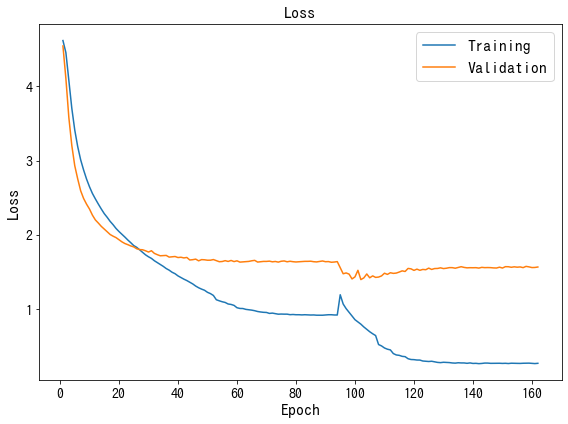

In [27]:
plt.figure(figsize=(8, 6))
h = history.history

loss = stage1_loss + h['loss']
val_loss = stage1_val_loss + h['val_loss']
ep = np.arange(1, len(loss) + 1)
plt.title('Loss', fontsize=16)
plt.plot(ep, loss, label='Training')
plt.plot(ep, val_loss, label='Validation')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.tight_layout()
save_fig(plt, file_prefix=os.path.join(model_dir, 'Loss'))
plt.show()

## 正解率のプロット

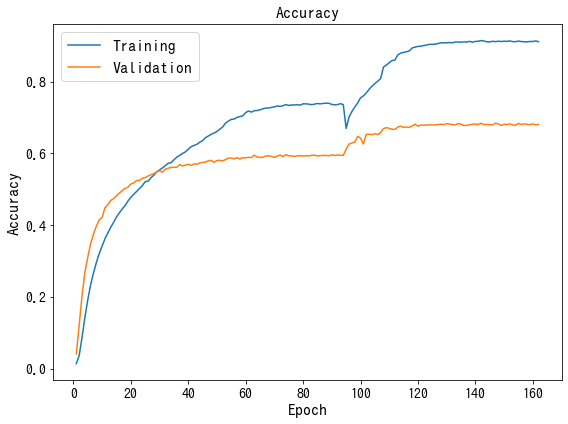

In [28]:
plt.figure(figsize=(8, 6))
h = history.history

acc = stage1_acc + h['acc']
val_acc = stage1_val_acc + h['val_acc']
ep = np.arange(1, len(loss) + 1)
plt.title('Accuracy', fontsize=16)
plt.plot(ep, acc, label='Training')
plt.plot(ep, val_acc, label='Validation')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.tight_layout()
save_fig(plt, file_prefix=os.path.join(model_dir, 'Loss'))
plt.show()

## 汎化能力の推定

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns

def evalulate(y_true, y_pred, file_prefix=''):
    
    cm = confusion_matrix(y_true, y_pred)
#     print(cm)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    print('正解率')
    print(f' {accuracy}')
    
    class_labels = []
    for i in range(y_true.max() + 1):
        class_labels.append(f'{i:4d}')
    
    precision_str = []
    recall_str = []
    for i in range(y_true.max() + 1):
        precision_str.append(f'{precision[i]}')
        recall_str.append(f'{recall[i]}')

    print('精度')
    print(' ' + ' '.join(class_labels))
    print(' ' + ' '.join(precision_str))
                             
    print('再現率')
    print(' ' + ' '.join(class_labels))
    print(' ' + ' '.join(recall_str))

    plt.figure(figsize = (10,7))
    sns.heatmap(cm, annot=True, fmt='3d', square=True, cmap='hot')
    plt.tight_layout()
    save_fig(plt, file_prefix=file_prefix)
    plt.show()

正解率
 0.6905445544554455
精度
    0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80   81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96   97   98   99  100
 0.43661971830985913 0.6908212560386473 0.751219512195122 0.7448979591836735 0.6262626262626263 0.5925925925925926 0.7302325581395349 0.8284313725490197 0.5393258426966292 0.5604395604395604 0.6373626373626373 0.7393364928909952 0.7789473684210526 0.6621004566210046 0.7272727272727273 0.5145631067961165 0.6788990825688074 0.4875 0.6646706586826348 0.6525821596244131 0.7512953367875648 0.5497630331753555 0.4075829383886256 0.7368421052631579 0.7766497461928934 0.6

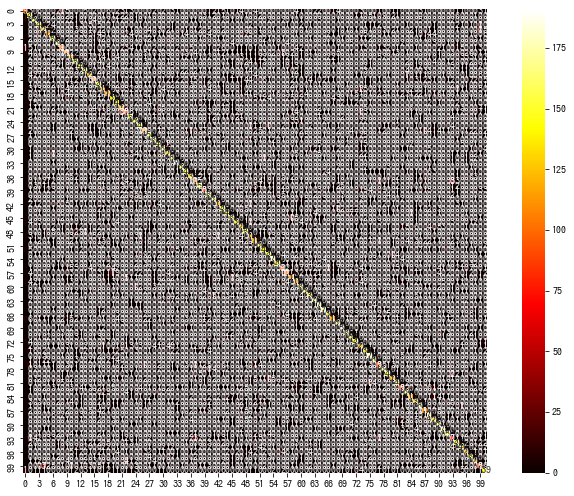

In [30]:
import pathlib

checkpoints = pathlib.Path(model_dir).glob('*.h5')
checkpoints = sorted(checkpoints, key=lambda cp:cp.stat().st_mtime)

latest = str(checkpoints[-1])
model.load_weights(latest)

batch_size = 25
img_seq_validation = ImageSequence(val_list, val_labels, shuffle=False, batch_size=batch_size)

y_pred = model.predict_generator(img_seq_validation)
y_pred_classes = y_pred.argmax(axis=1)
y_true = np.array(val_labels)
evalulate(y_true, y_pred_classes, file_prefix=os.path.join(model_dir, 'cm'))